# MONAI : Tutorial : modules
## POstprocessing Transforms with spleen segmentation task

参照URL:
- https://github.com/Project-MONAI/tutorials/blob/main/modules/postprocessing_transforms.ipynb

## 0. 準備

In [1]:
# パッケージのインストール
#!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, skimage, tqdm]"
#!python -c "import matplotlib" || pip install -q matplotlib

In [2]:
# パッケージのインポート
import warnings
warnings.simplefilter('ignore')

import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    KeepLargestConnectedComponent,
    LabelToContour,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/akira/venv/monai/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.26.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installi

In [3]:
# データディレクトリ
root_dir = './data/MSD'

In [4]:
# データダウンロード
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, 'Task09_Spleen.tar')
data_dir = os.path.join(root_dir, 'Task09_Spleen')
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [5]:
# 乱数シードの設定
set_determinism(seed=2023)

## 1. データセット, データローダ

In [6]:
train_images = sorted(glob(os.path.join(data_dir, 'imagesTr', '*.nii.gz')))
train_labels = sorted(glob(os.path.join(data_dir, 'labelsTr', '*.nii.gz')))

data_dicts = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # randomly crop out patch samples from big image
        # based on pos / neg ratio. the image centers
        # of negative samples must be in valid image area
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
)

In [8]:
train_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=['image', 'label']),
        Orientationd(keys=['image', 'label'], axcodes='RAS'),
        Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.0), mode=('bilinear', 'nearest')),
        ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        RandCropByPosNegLabeld(keys=['image', 'label'], label_key='label', spatial_size=(96, 96, 96),
                              pos=1, neg=1, num_samples=4, image_key='image', image_threshold=0,),
        EnsureTyped(keys=['image', 'label'])
    ]
)

In [9]:
val_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=['image', 'label']),
        Orientationd(keys=['image', 'label'], axcodes='RAS'),
        Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.0), mode=('bilinear', 'nearest')),
        ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        EnsureTyped(keys=['image', 'label']),
    ]
)

In [10]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|████████████████████████████| 9/9 [00:05<00:00,  1.69it/s]


## 2. モデル定義

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [13]:
loss_function = DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=True, batch=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
dice_metric = DiceMetric(include_background=False, reduction='mean')

In [14]:
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

## 3. 学習

In [15]:
model_dir = 'models/post_transforms'
os.makedirs(model_dir, exist_ok=True)

max_epochs = 100
val_interval = 2

In [16]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

# epochループ
for epoch in range(max_epochs):
    print('-' * 10)
    print(f'epoch {epoch + 1}/{max_epochs}')
    model.train()
    epoch_loss = 0
    step = 0
    
    # mini batchループ
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data['image'].to(device),
            batch_data['label'].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f'{step}/{len(train_ds) // train_loader.batch_size}, '
              f'train_loss: {loss.item():.4f}')
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f'epoch {epoch + 1} average loss: {epoch_loss:.4f}')
    
    # 評価
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data['image'].to(device),
                    val_data['label'].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)
            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(model_dir, 'best_metric_model.pth'))
                print('save new best metric model')
            print(
                f'current epoch: {epoch + 1} current mean dice: {metric:.4f}'
                f'\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}'
            )

----------
epoch 1/100
1/16, train_loss: 1.2862
2/16, train_loss: 1.2934
3/16, train_loss: 1.2847
4/16, train_loss: 1.2992
5/16, train_loss: 1.3140
6/16, train_loss: 1.2714
7/16, train_loss: 1.2674
8/16, train_loss: 1.2674
9/16, train_loss: 1.2520
10/16, train_loss: 1.2197
11/16, train_loss: 1.2127
12/16, train_loss: 1.2250
13/16, train_loss: 1.2227
14/16, train_loss: 1.1947
15/16, train_loss: 1.1687
16/16, train_loss: 1.2029
epoch 1 average loss: 1.2489
----------
epoch 2/100
1/16, train_loss: 1.2136
2/16, train_loss: 1.1843
3/16, train_loss: 1.1056
4/16, train_loss: 1.1335
5/16, train_loss: 1.1393
6/16, train_loss: 1.1318
7/16, train_loss: 1.0893
8/16, train_loss: 1.1610
9/16, train_loss: 1.1423
10/16, train_loss: 1.1129
11/16, train_loss: 1.1893
12/16, train_loss: 1.1238
13/16, train_loss: 1.1344
14/16, train_loss: 1.1244
15/16, train_loss: 1.0532
16/16, train_loss: 1.1183
epoch 2 average loss: 1.1348
save new best metric model
current epoch: 2 current mean dice: 0.0430
best mean di

3/16, train_loss: 0.6394
4/16, train_loss: 0.6985
5/16, train_loss: 0.6327
6/16, train_loss: 0.6120
7/16, train_loss: 0.5949
8/16, train_loss: 0.6522
9/16, train_loss: 0.5052
10/16, train_loss: 0.7991
11/16, train_loss: 0.6387
12/16, train_loss: 0.6221
13/16, train_loss: 0.5099
14/16, train_loss: 0.6740
15/16, train_loss: 0.5475
16/16, train_loss: 0.6697
epoch 17 average loss: 0.6372
----------
epoch 18/100
1/16, train_loss: 0.5137
2/16, train_loss: 0.6570
3/16, train_loss: 0.5307
4/16, train_loss: 0.7466
5/16, train_loss: 0.6493
6/16, train_loss: 0.6627
7/16, train_loss: 0.6482
8/16, train_loss: 0.4945
9/16, train_loss: 0.5216
10/16, train_loss: 0.5883
11/16, train_loss: 0.6100
12/16, train_loss: 0.6078
13/16, train_loss: 0.5754
14/16, train_loss: 0.4807
15/16, train_loss: 0.4825
16/16, train_loss: 0.5947
epoch 18 average loss: 0.5852
current epoch: 18 current mean dice: 0.7154
best mean dice: 0.8225 at epoch: 16
----------
epoch 19/100
1/16, train_loss: 0.5862
2/16, train_loss: 0.560

7/16, train_loss: 0.3279
8/16, train_loss: 0.3570
9/16, train_loss: 0.3029
10/16, train_loss: 0.4596
11/16, train_loss: 0.3296
12/16, train_loss: 0.2355
13/16, train_loss: 0.2972
14/16, train_loss: 0.3172
15/16, train_loss: 0.2664
16/16, train_loss: 0.3484
epoch 33 average loss: 0.3121
----------
epoch 34/100
1/16, train_loss: 0.3076
2/16, train_loss: 0.2941
3/16, train_loss: 0.3845
4/16, train_loss: 0.2709
5/16, train_loss: 0.2505
6/16, train_loss: 0.2577
7/16, train_loss: 0.2202
8/16, train_loss: 0.3113
9/16, train_loss: 0.2598
10/16, train_loss: 0.3571
11/16, train_loss: 0.4309
12/16, train_loss: 0.3345
13/16, train_loss: 0.2146
14/16, train_loss: 0.3754
15/16, train_loss: 0.2758
16/16, train_loss: 0.2983
epoch 34 average loss: 0.3027
current epoch: 34 current mean dice: 0.8836
best mean dice: 0.8931 at epoch: 30
----------
epoch 35/100
1/16, train_loss: 0.3093
2/16, train_loss: 0.2385
3/16, train_loss: 0.3041
4/16, train_loss: 0.3500
5/16, train_loss: 0.3592
6/16, train_loss: 0.232

13/16, train_loss: 0.1916
14/16, train_loss: 0.1769
15/16, train_loss: 0.1312
16/16, train_loss: 0.1937
epoch 49 average loss: 0.1810
----------
epoch 50/100
1/16, train_loss: 0.1709
2/16, train_loss: 0.1367
3/16, train_loss: 0.1233
4/16, train_loss: 0.1806
5/16, train_loss: 0.2758
6/16, train_loss: 0.1324
7/16, train_loss: 0.1568
8/16, train_loss: 0.1359
9/16, train_loss: 0.1766
10/16, train_loss: 0.1624
11/16, train_loss: 0.1442
12/16, train_loss: 0.1282
13/16, train_loss: 0.1786
14/16, train_loss: 0.1348
15/16, train_loss: 0.1488
16/16, train_loss: 0.2523
epoch 50 average loss: 0.1649
current epoch: 50 current mean dice: 0.8908
best mean dice: 0.9062 at epoch: 36
----------
epoch 51/100
1/16, train_loss: 0.1278
2/16, train_loss: 0.1574
3/16, train_loss: 0.1429
4/16, train_loss: 0.2895
5/16, train_loss: 0.1728
6/16, train_loss: 0.1651
7/16, train_loss: 0.1599
8/16, train_loss: 0.1841
9/16, train_loss: 0.1691
10/16, train_loss: 0.1350
11/16, train_loss: 0.1169
12/16, train_loss: 0.171

1/16, train_loss: 0.0943
2/16, train_loss: 0.1003
3/16, train_loss: 0.0961
4/16, train_loss: 0.0915
5/16, train_loss: 0.1564
6/16, train_loss: 0.1034
7/16, train_loss: 0.1324
8/16, train_loss: 0.1036
9/16, train_loss: 0.0971
10/16, train_loss: 0.0907
11/16, train_loss: 0.1006
12/16, train_loss: 0.0966
13/16, train_loss: 0.1391
14/16, train_loss: 0.1107
15/16, train_loss: 0.1002
16/16, train_loss: 0.0913
epoch 66 average loss: 0.1065
current epoch: 66 current mean dice: 0.9150
best mean dice: 0.9235 at epoch: 56
----------
epoch 67/100
1/16, train_loss: 0.1058
2/16, train_loss: 0.0955
3/16, train_loss: 0.0921
4/16, train_loss: 0.1287
5/16, train_loss: 0.0930
6/16, train_loss: 0.0988
7/16, train_loss: 0.0840
8/16, train_loss: 0.1819
9/16, train_loss: 0.1396
10/16, train_loss: 0.0921
11/16, train_loss: 0.1141
12/16, train_loss: 0.1030
13/16, train_loss: 0.0941
14/16, train_loss: 0.1260
15/16, train_loss: 0.1040
16/16, train_loss: 0.1001
epoch 67 average loss: 0.1096
----------
epoch 68/10

5/16, train_loss: 0.0807
6/16, train_loss: 0.0665
7/16, train_loss: 0.0762
8/16, train_loss: 0.0762
9/16, train_loss: 0.0647
10/16, train_loss: 0.0671
11/16, train_loss: 0.0860
12/16, train_loss: 0.0883
13/16, train_loss: 0.0974
14/16, train_loss: 0.0852
15/16, train_loss: 0.0797
16/16, train_loss: 0.0726
epoch 82 average loss: 0.0780
current epoch: 82 current mean dice: 0.9061
best mean dice: 0.9358 at epoch: 78
----------
epoch 83/100
1/16, train_loss: 0.0739
2/16, train_loss: 0.0878
3/16, train_loss: 0.0723
4/16, train_loss: 0.0871
5/16, train_loss: 0.0595
6/16, train_loss: 0.0831
7/16, train_loss: 0.1010
8/16, train_loss: 0.0720
9/16, train_loss: 0.0883
10/16, train_loss: 0.0622
11/16, train_loss: 0.0942
12/16, train_loss: 0.0832
13/16, train_loss: 0.0937
14/16, train_loss: 0.0769
15/16, train_loss: 0.0618
16/16, train_loss: 0.0762
epoch 83 average loss: 0.0796
----------
epoch 84/100
1/16, train_loss: 0.0790
2/16, train_loss: 0.0852
3/16, train_loss: 0.0855
4/16, train_loss: 0.066

12/16, train_loss: 0.0602
13/16, train_loss: 0.1002
14/16, train_loss: 0.0628
15/16, train_loss: 0.0678
16/16, train_loss: 0.0559
epoch 98 average loss: 0.0650
current epoch: 98 current mean dice: 0.9247
best mean dice: 0.9358 at epoch: 78
----------
epoch 99/100
1/16, train_loss: 0.0509
2/16, train_loss: 0.0626
3/16, train_loss: 0.0568
4/16, train_loss: 0.0663
5/16, train_loss: 0.0604
6/16, train_loss: 0.0607
7/16, train_loss: 0.0606
8/16, train_loss: 0.0572
9/16, train_loss: 0.0475
10/16, train_loss: 0.0675
11/16, train_loss: 0.0572
12/16, train_loss: 0.0611
13/16, train_loss: 0.0610
14/16, train_loss: 0.0635
15/16, train_loss: 0.0565
16/16, train_loss: 0.0621
epoch 99 average loss: 0.0595
----------
epoch 100/100
1/16, train_loss: 0.0513
2/16, train_loss: 0.0715
3/16, train_loss: 0.0566
4/16, train_loss: 0.0549
5/16, train_loss: 0.0606
6/16, train_loss: 0.0572
7/16, train_loss: 0.0784
8/16, train_loss: 0.0698
9/16, train_loss: 0.0701
10/16, train_loss: 0.0599
11/16, train_loss: 0.06

## 4. 後処理変換

In [17]:
model.load_state_dict(torch.load(os.path.join(model_dir, 'best_metric_model.pth')))

<All keys matched successfully>

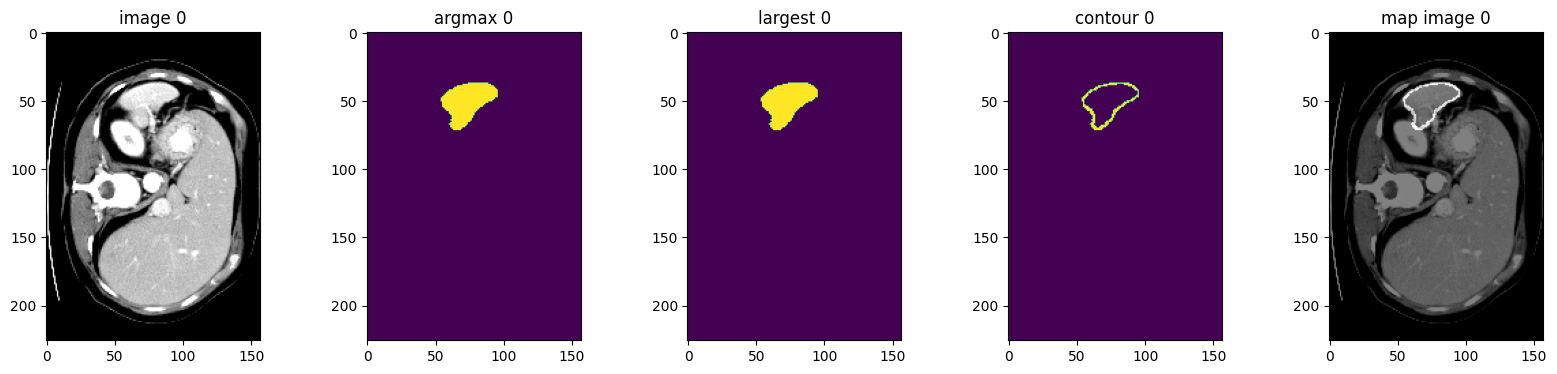

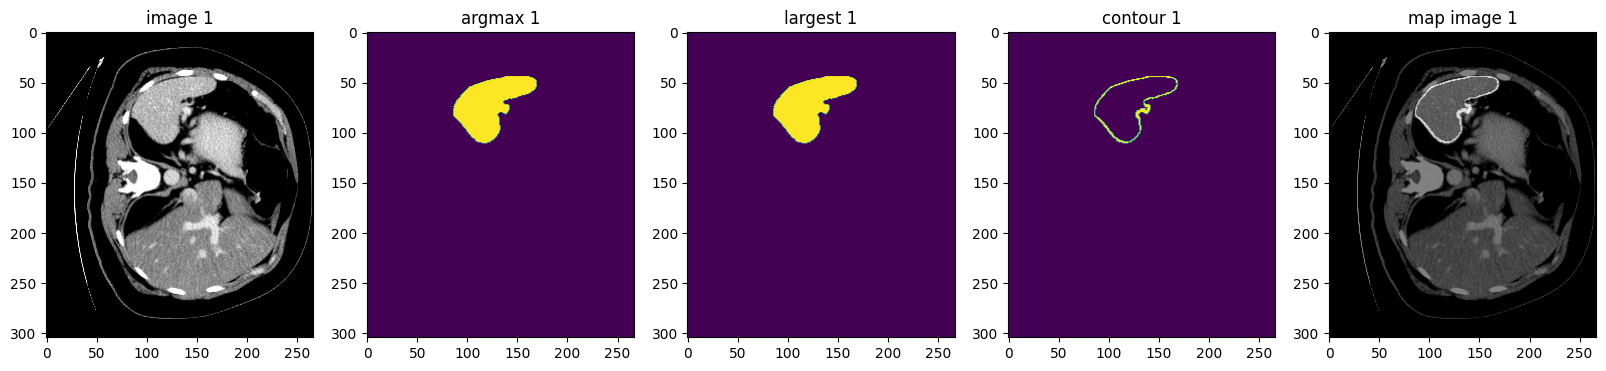

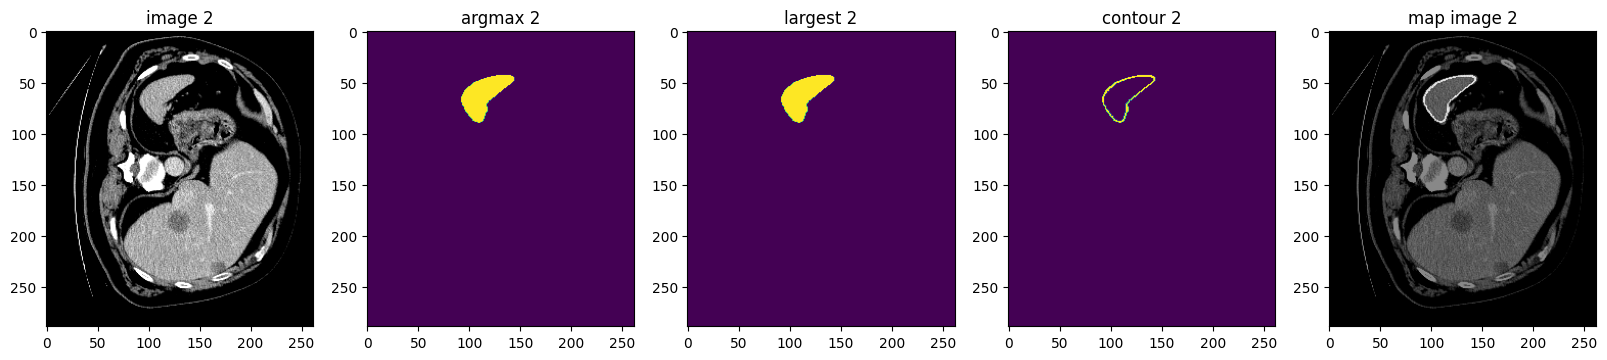

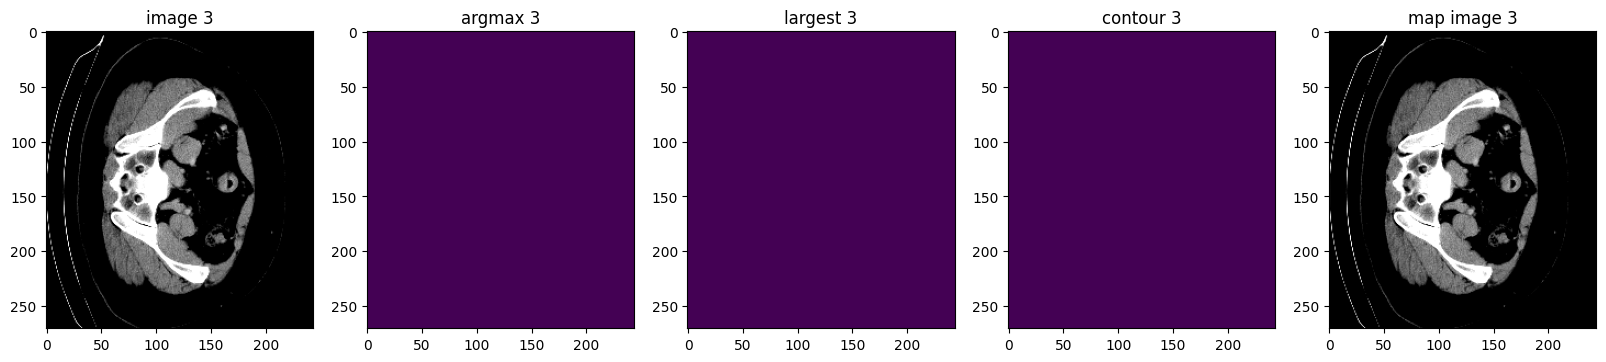

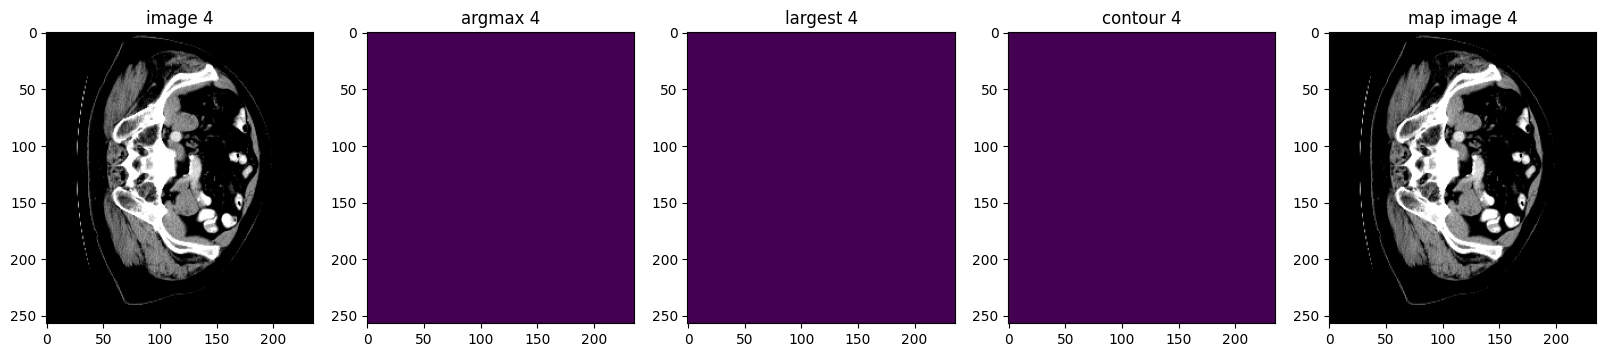

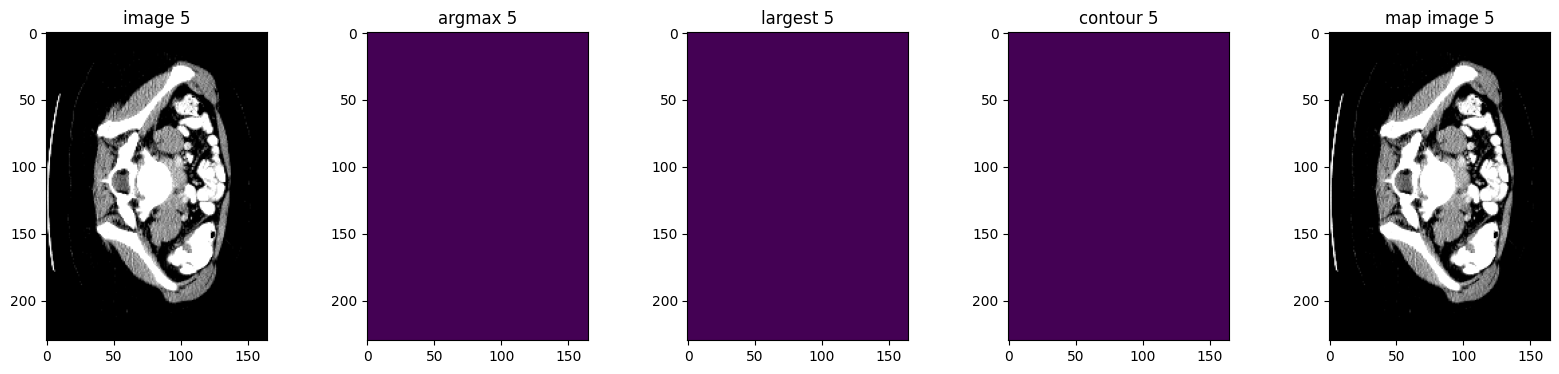

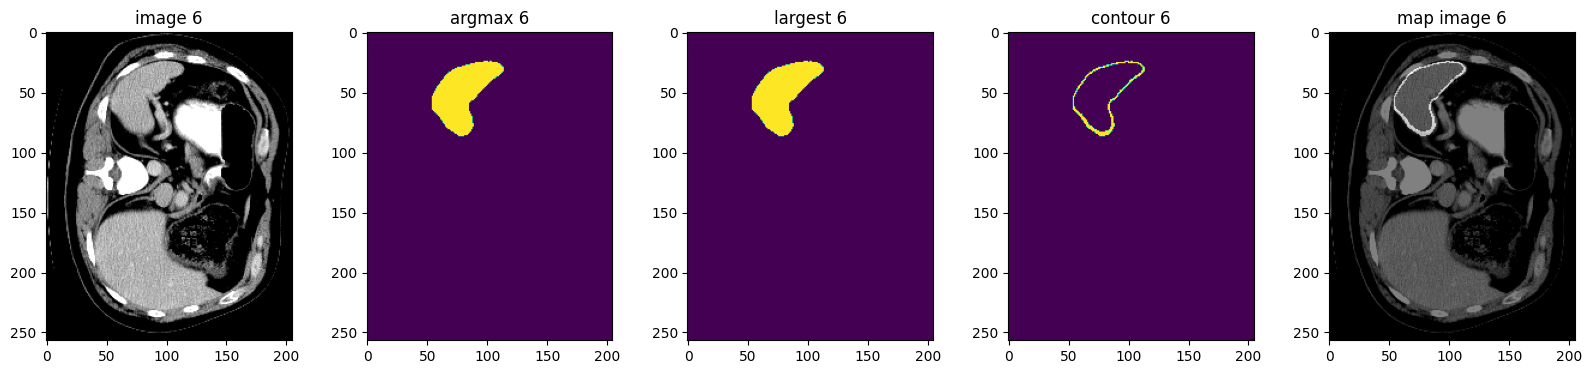

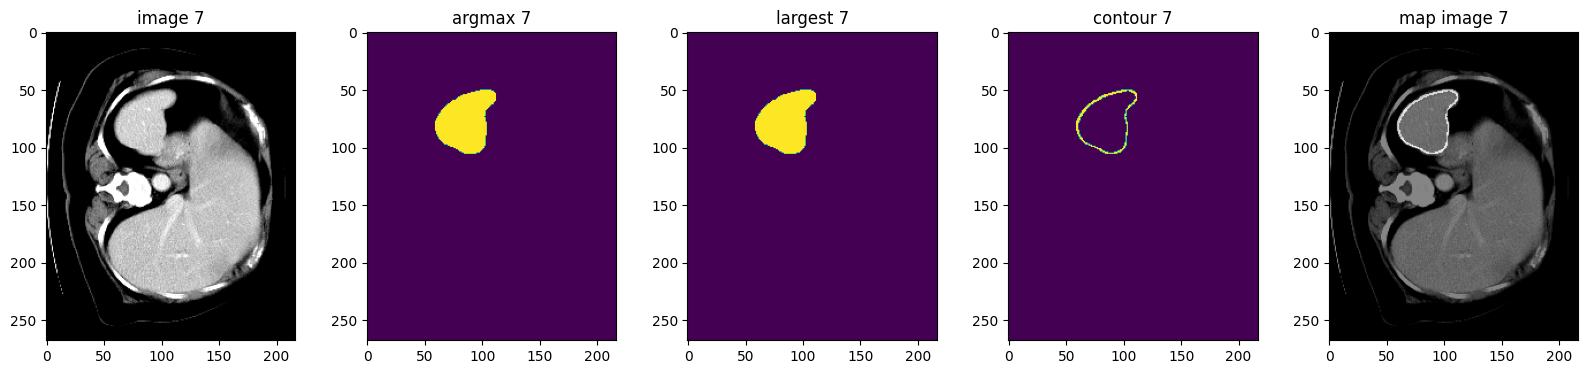

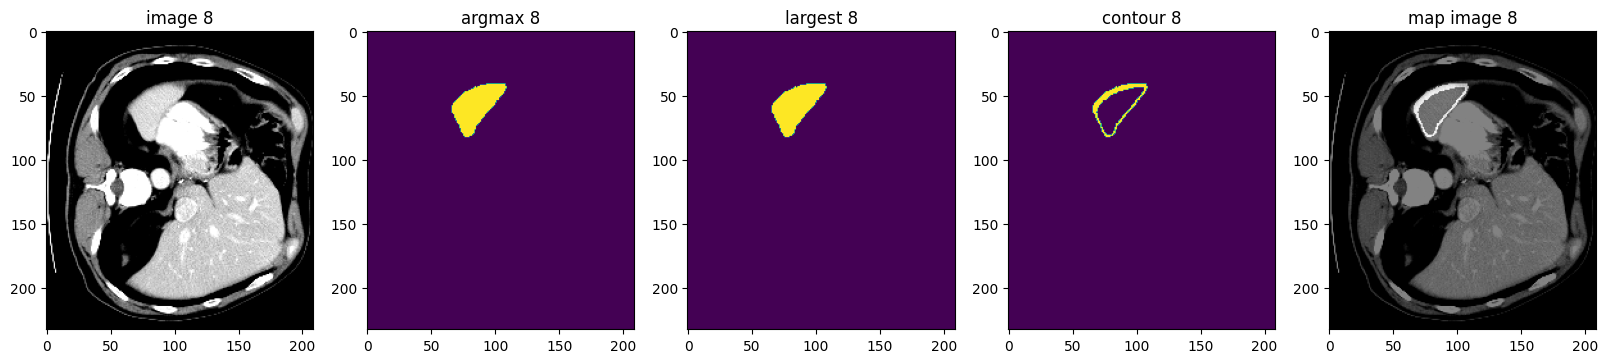

In [18]:
model.eval()

with torch.no_grad():
    roi_size = (160, 160, 160)
    sw_batch_size = 4
    for i, val_data in enumerate(val_loader):
        val_data = val_data['image'].to(device)
        val_output = sliding_window_inference(val_data, roi_size, sw_batch_size, model)
        
        # plot the slice [:, :, 80]
        plt.figure('check', figsize=(20, 4))
        plt.subplot(1, 5, 1)
        plt.title(f'image {i}')
        plt.imshow(val_data.detach().cpu()[0, 0, :, :, 80], cmap='gray')
        
        plt.subplot(1, 5, 2)
        plt.title(f'argmax {i}')
        argmax = [AsDiscrete(argmax=True)(i) for i in decollate_batch(val_output)]
        plt.imshow(argmax[0].detach().cpu()[0, :, :, 80])
        
        plt.subplot(1, 5, 3)
        plt.title(f'largest {i}')
        largest = [KeepLargestConnectedComponent(applied_labels=[1])(i) for i in argmax]
        plt.imshow(largest[0].detach().cpu()[0, :, :, 80])
        
        plt.subplot(1, 5, 4)
        plt.title(f'contour {i}')
        contour = [LabelToContour()(i) for i in largest]
        plt.imshow(contour[0].detach().cpu()[0, :, :, 80])
        
        plt.subplot(1, 5, 5)
        plt.title(f'map image {i}')
        map_image = contour[0] + val_data[0]
        plt.imshow(map_image.detach().cpu()[0, :, :, 80], cmap='gray')
        
        plt.show()
        